# Projeto 1
Nosso primeiro projeto avaliativo, consistindo em 15% da nota final no curso, será uma aplicação de aprendizado supervisionado: classificar discursos presidenciais feitos para audiências internacionais. Ao todo, são 350 discursos proferidos por Lula, Dilma e Temer que poderão ser utilizados para teste e treino de modelos. Neste trabalho, vocês poderão aplicar o pré-processamento que julgarem mais adequado.

## Descrição dos procedimentos:

Para essa atividade, serão realizados:
* Dois pré-processamentos de dados com e sem stem: essa abordagem parece mais adequada já que não conhecemos o resultado de processo desse stem.
* Aplicação de um algoritmo de NaiveBayes.
* Aplicação de um algoritmo de Floresta Aleatória.
* Depois do treinamento dos algoritmos, vamos monitorar o recall e psteriormenete serão selecionados 2 algortimos.
* Para finalizar, serão aplicados os algoritmos a base de teste e calculado o indice de Krippendorff.
* Como a implementação do índice de Krinppendorff não parece confiável, será aplicado um índice de 'concordância' entre os dois algoritmos selecionados, uma possibilidade metodológica seria utilizar uma codificador humano ou um novo algoritmo como terceiro juiz.


In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import RSLPStemmer
from sklearn import metrics
import matplotlib.pyplot as plt
import re
import unidecode
from nltk.corpus import stopwords
import numpy as np
import krippendorff


In [2]:
link = 'https://github.com/FLS-6497/datasets/blob/main/projeto1/discursos_pres_internacionais.csv?raw=true'
discursos = pd.read_csv(link, sep=';')

link = 'https://github.com/FLS-6497/datasets/blob/main/projeto1/discursos_pres_internacionais_validacao.csv?raw=true'
validacao = pd.read_csv(link, sep=';')

## Explorar dados


In [3]:
discursos.head()

,data,presidente,discurso
0,2018-11-30,Temer,"\nHá uma década, desencadeava-se crise econômi..."
1,2018-11-30,Temer,"\nAntes de mais nada, cumprimento o Presidente..."
2,2018-11-30,Temer,\nDiscurso do presidente Michel Temer\nSenhor ...
3,2018-09-25,Temer,"\nSenhora Presidente desta Assembleia Geral, M..."
4,2018-06-18,Temer,"\nPrezados amigos,\nPresidentes, vice-presiden..."


In [4]:
discursos["presidente"].unique()

array(['Temer', 'Dilma', 'Lula'], dtype=object)

In [5]:
discursos['presidente'].value_counts()

Lula     145
Dilma    131
Temer     74
Name: presidente, dtype: int64

In [6]:
stopwords_pt =  stopwords.words('portuguese')
print(stopwords_pt)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

## Processamento

Em ambos os processamentos são:
* Retiradas palavras com menos de 4 caracteres,
* Removidos os acentos,
* Retiradas palavras na lista de stopwords,
* Palavras são transformadas em minúsculo.

No processamento 1, o discurso sofre um processo de stemmização com um algoritmo criado para o português.



In [7]:
def Processamento1(texto):
    tokens = word_tokenize(texto,language="portuguese")
    tokens = [t for t in tokens if len(t) > 4]
    tokens = [t for t in tokens if t not in stopwords_pt]
    
    tokens = [t.lower() for t in tokens]
    tokens = [unidecode.unidecode(t) for t in tokens]
    stem = RSLPStemmer()
    token_stem = [stem.stem(t) for t in tokens]
    return " ".join(token_stem)

def Processamento2(texto):
    tokens = word_tokenize(texto,language="portuguese")
    tokens = [t for t in tokens if len(t) > 4]
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [t.lower() for t in tokens]
    tokens = [unidecode.unidecode(t) for t in tokens]
    return " ".join(tokens)


In [8]:
p_discursos1 = [Processamento1(discurso) for discurso in discursos['discurso']]
p_discursos2 = [Processamento2(discurso) for discurso in discursos['discurso']]

In [9]:
discursos['discurso1'] = p_discursos1
discursos['discurso2'] = p_discursos2

In [10]:
discursos.head()

,data,presidente,discurso,discurso1,discurso2
0,2018-11-30,Temer,"\nHá uma década, desencadeava-se crise econômi...",dec desencadeava-s cris econom efeit sistem ne...,decada desencadeava-se crise economica efeitos...
1,2018-11-30,Temer,"\nAntes de mais nada, cumprimento o Presidente...",ant cumpr presid macr govern argentin impeca o...,antes cumprimento presidente macri governo arg...
2,2018-11-30,Temer,\nDiscurso do presidente Michel Temer\nSenhor ...,discurs presid michel tem senh presid senh sen...,discurso presidente michel temer senhor presid...
3,2018-09-25,Temer,"\nSenhora Presidente desta Assembleia Geral, M...",senh presid dest assemble geral mar fernand es...,senhora presidente desta assembleia geral mari...
4,2018-06-18,Temer,"\nPrezados amigos,\nPresidentes, vice-presiden...",prez amig presid vice-presid horaci cart tab v...,prezados amigos presidentes vice-presidentes h...


## Modelos
Abaixo estão as funções com os dois modelos que serão utilizados, NaiveBayes e Floresta Aleatória

In [11]:
def Contagemtdf(base,coluna_X, coluna_Y):
    Base_discursos = base
    X_train, X_test, Y_train, Y_test = train_test_split(Base_discursos[coluna_X], Base_discursos[coluna_Y], test_size=0.7)
    tfid_1 = TfidfVectorizer(analyzer='word',min_df=0.1)
    X_train_corpus = tfid_1.fit_transform(X_train) 
    X_test_corpus = tfid_1.transform(X_test)    
    return X_train_corpus, X_test_corpus, Y_train, Y_test, tfid_1

def ModeloNB(X_train_corpus, X_test_corpus, Y_train, Y_test): 

    nb_classifier = MultinomialNB()   
    nb_classifier.fit(X_train_corpus, Y_train)    
    pred = nb_classifier.predict(X_test_corpus)
    score = metrics.recall_score(Y_test,pred,average='micro')
    cm = metrics.confusion_matrix(Y_test,pred,labels=Y_test.unique())
    
    return score,cm, Y_test, pred, nb_classifier

def ModeloRF(X_train_corpus, X_test_corpus, Y_train, Y_test):
    rf_classifier = RandomForestClassifier()   
    rf_classifier.fit(X_train_corpus, Y_train)    
    pred = rf_classifier.predict(X_test_corpus)
    score = metrics.recall_score(Y_test,pred,average='micro')
    cm = metrics.confusion_matrix(Y_test,pred,labels=Y_test.unique())
    
    return score,cm, Y_test, pred, nb_classifier

In [12]:
X_train_corpus, X_test_corpus, Y_train, Y_test, tfid1 = Contagemtdf(discursos,"discurso2","presidente")

In [13]:
score,cm, Y_test, pred, nb_classifier = ModeloNB(X_train_corpus, X_test_corpus, Y_train, Y_test)

In [14]:
score,cm, Y_test, pred, nb_classifier = ModeloRF(X_train_corpus, X_test_corpus, Y_train, Y_test)

## Escolha do modelo
Para escolher os modelos e os pré-processamentos, serão selecionados os 2 modelos (combinados com pré-processamento) que apresentarem a maior Recall média.

In [15]:
#Escolha de modelos e processamento

score_pre1_NB = []
score_pre2_NB = []
score_pre1_RF = []
score_pre2_RF = []

for n in range(1,101):
    X_train_corpus, X_test_corpus, Y_train, Y_test,tfid1 = Contagemtdf(discursos,"discurso1","presidente")
    
    score,cm, Y_test, pred, nb_classifier = ModeloNB(X_train_corpus, X_test_corpus, Y_train, Y_test)
    score_pre1_NB.append(score)

    score,cm, Y_test, pred, nb_classifier = ModeloRF(X_train_corpus, X_test_corpus, Y_train, Y_test)
    score_pre1_RF.append(score)

    X_train_corpus, X_test_corpus, Y_train, Y_test,tfid1 = Contagemtdf(discursos,"discurso2","presidente")
    
    score,cm, Y_test, pred, nb_classifier = ModeloNB(X_train_corpus, X_test_corpus, Y_train, Y_test)
    score_pre2_NB.append(score)

    score,cm, Y_test, pred, nb_classifier = ModeloRF(X_train_corpus, X_test_corpus, Y_train, Y_test)
    score_pre2_RF.append(score)

    


In [16]:
resultados = pd.DataFrame([score_pre1_NB,score_pre2_NB,score_pre1_RF,score_pre2_RF]).T
resultados.rename({0:'NB_Pre1',1:'NB_Pre2',2:'RF_Pre1',3:'RF_Pre2'},axis=1, inplace= True)

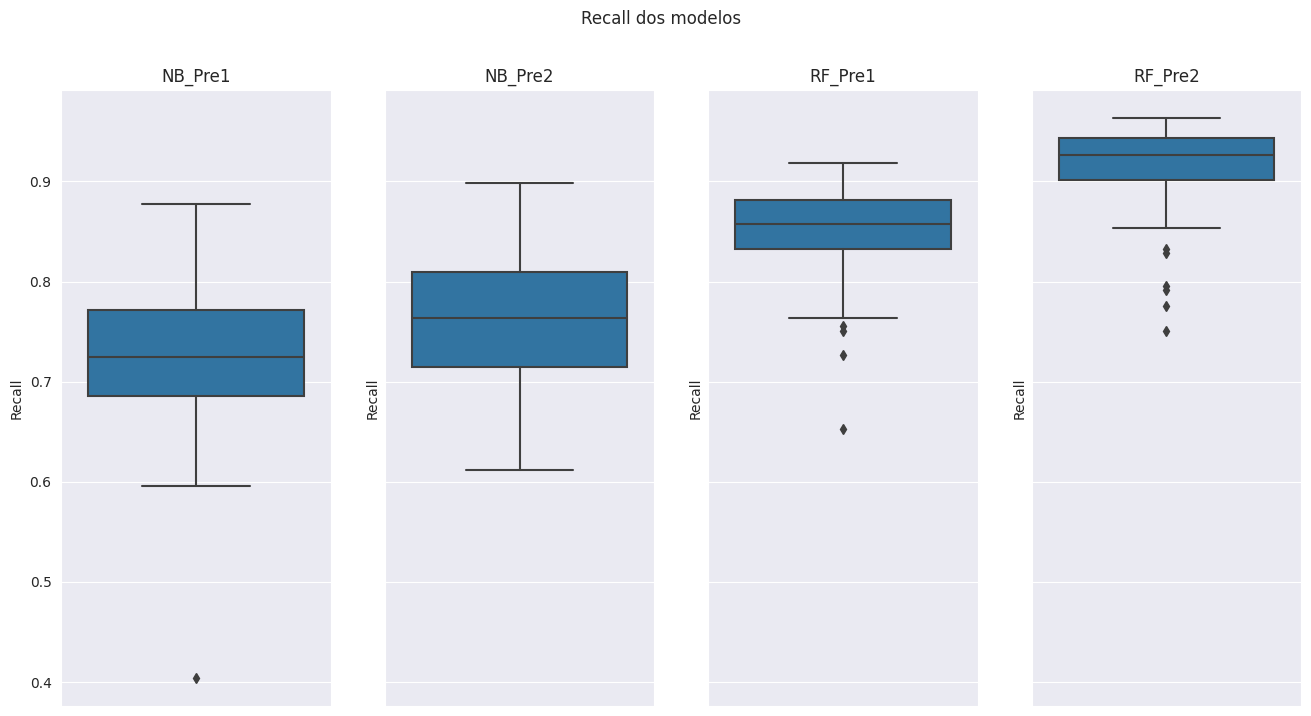

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,4,sharey=True,figsize=(16,8))
fig.suptitle("Recall dos modelos")
for i in range(0,4):
    temp = resultados.iloc[:,i]
    nome = resultados.columns[i]
    sns.boxplot(ax=ax[i],y=temp)
    ax[i].set_title(nome)
    ax[i].set(ylabel="Recall")



### Comentário

Entre os processamentos, os modelos que apresentam uma melhor perfomance são os modelos que não utilizam o processo de stemmização, mesmo que o modelo de floresta aleatória (3) apresente um resultado um pouco superior ao Naive Bayes (2), há ainda a oportunidade de se otimizar o modelo de Naive Bayes através do alpha (Otimização de Laplace)

In [18]:
def ModeloNB_a(X_train_corpus, X_test_corpus, Y_train, Y_test, alpha): 

    nb_classifier = MultinomialNB(alpha=alpha)   
    nb_classifier.fit(X_train_corpus, Y_train)    
    pred = nb_classifier.predict(X_test_corpus)
    score = metrics.c(Y_test,pred,average='micro')
    cm = metrics.confusion_matrix(Y_test,pred,labels=Y_test.unique())
    
    return score,cm, Y_test, pred, nb_classifier

In [19]:
X_train_corpus, X_test_corpus, Y_train, Y_test, tfid1 = Contagemtdf(discursos,"discurso2","presidente")
recall_lista = []  
alphas = np.arange(0.1,1.1,0.1)  
for x in alphas:
    score,cm, Y_test, pred, nb_classifier = ModeloNB_a(X_train_corpus, X_test_corpus, Y_train, Y_test, x)
    recall_lista.append(score)
    

[0.9224489795918367, 0.9020408163265307, 0.8653061224489796, 0.8163265306122449, 0.7836734693877551, 0.7551020408163265, 0.7428571428571429, 0.726530612244898, 0.7183673469387755, 0.710204081632653]


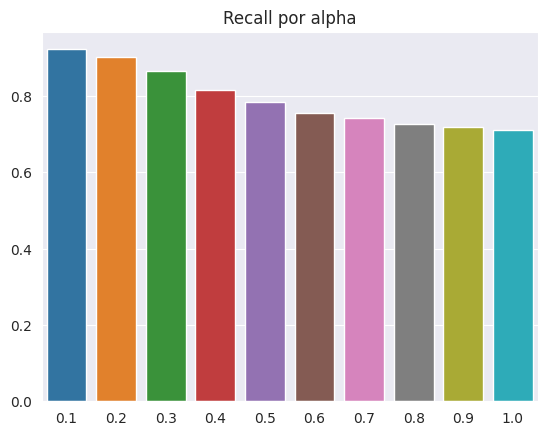

In [20]:
g = sns.barplot(y=recall_lista,x=np.round(alphas,1),label=recall_lista)
g.set(title="Recall por alpha")
print(recall_lista)

### Comentário
Aparentemente o melhor resultado seria com alpha 0.1.

Com isso, podemos rodar os modelos escolhidos para as amostras e calcular o alpha de Krippendorff

In [21]:
X_train_corpus, X_test_corpus, Y_train, Y_test, tfid1 = Contagemtdf(discursos,"discurso2","presidente")
score_nb, cm_nb, Y_test_nb, pred_nb, nb_classifier = ModeloNB_a(X_train_corpus, X_test_corpus, Y_train, Y_test, 0.1)
score_rf, cm_rf, Y_test_rf, pred_rf, rf_classifier = ModeloRF(X_train_corpus, X_test_corpus, Y_train, Y_test)


In [22]:
print("Checagem de dataframe Y: ",  Y_test_nb.equals(Y_test_rf))
print("Recall Score: ", score_nb, " (nb) ", score_rf, " (rf) ")

Checagem de dataframe Y:  True
Recall Score:  0.9183673469387755  (nb)  0.9061224489795918  (rf) 


In [23]:
#temp_df = pd.DataFrame([pred_nb,pred_rf]).T
#temp_df = temp_df.replace("Dilma",0)
#temp_df = temp_df.replace("Lula",1)
#temp_df = temp_df.replace("Temer",2)
#temp_df_array = temp_df.to_numpy()
#krippendorff.alpha(value_counts=np.asmatrix(temp_df_array))

In [24]:
temp_df = pd.DataFrame([pred_nb,pred_rf]).T
temp_df.rename({0:"NB",1:"RF"},axis=1,inplace=True)
temp_df['Concordam'] = temp_df['NB'] == temp_df['RF']
sum(temp_df['Concordam'])/245

0.8857142857142857

### Comentário 

Não foi possível implentar o krippendorff, mas o resultado de 'concordância' ficou em torno 80-89%. 
Para implementar o algortimo, podemos utilizar um terceio modelo que funcionaria como critério de 'desempate', ou ainda adicionar codificação humana. 

Neste exercício, usaremos a classificação de RandomForest como 'desempate'


In [25]:
v_discursos2 = [Processamento2(discurso) for discurso in validacao['discurso']]
validacao['v_discurso2'] = v_discursos2
v_matrix = tfid1.transform(validacao['v_discurso2'])

In [29]:
pred_nb_v = nb_classifier.predict(v_matrix)
pred_rf_v = rf_classifier.predict(v_matrix)
pred_valida = pd.DataFrame([pred_nb_v,pred_rf_v]).T
pred_valida.rename({0:"NB",1:"RF"},axis=1,inplace=True)
pred_valida['Concordam'] = pred_valida['NB'] == pred_valida['RF']
pred_valida = pd.concat([validacao,pred_valida],axis=1)
sum(pred_valida['Concordam'])/25

1.0

In [27]:
pred_valida.head()

,discurso,id,v_discurso2,NB,RF,Concordam
0,"\nExcelentíssimo senhor Shinzo Abe, primeiro-m...",137,excelentissimo senhor shinzo primeiro-ministro...,Dilma,Dilma,True
1,\nFoto: Roberto Stuckert Filho/PR \n \nSenhor ...,90,roberto stuckert filho/pr senhor laurent fabiu...,Dilma,Dilma,True
2,"\nExcelentíssimo senhor Paul Biya, presidente ...",229,excelentissimo senhor presidente cameroun senh...,Lula,Lula,True
3,"\nEu quero cumprimentar, em primeiro lugar, a ...",7,quero cumprimentar primeiro lugar senhora mari...,Temer,Temer,True
4,\nQuero dirigir um cumprimento especial à Zole...,91,quero dirigir cumprimento especial zoleka mand...,Dilma,Dilma,True


In [ ]:
pred_valida.to_excel("Validação.xlsx")